<a href="https://colab.research.google.com/github/ymerta/sms-spam-classification-NLP/blob/main/spamClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yakupmertakan","key":"8f927b208e0ae8851389420a9fbf5aed"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d uciml/sms-spam-collection-dataset

Dataset URL: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset
License(s): unknown
  0% 0.00/211k [00:00<?, ?B/s]
100% 211k/211k [00:00<00:00, 693MB/s]


In [4]:
!unzip sms-spam-collection-dataset.zip

Archive:  sms-spam-collection-dataset.zip
  inflating: spam.csv                


In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
import pandas as pd

# Dosyayı oku (gerekirse encoding değiştir)
df = pd.read_csv("spam.csv", encoding='latin-1')

# Gereksiz sütunları kaldır
df = df[['v1', 'v2']]
df.columns = ['label', 'text']

# İlk 5 satırı görüntüle
df.head()

label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

# Tokenization

In [7]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'[A-Za-z]+')
df["tokens"] = df["text"].astype(str).str.lower().apply(lambda x: tokenizer.tokenize(x))


print("Tokenized text :", *df["tokens"][:5], sep="\n")


Tokenized text :
['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 'over', 's']
['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']
['nah', 'i', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']


# Stopwords ve en sık geçen kelimeler

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-8-d7642a58566c>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


Cleaned tokens (stopwords + noise removed):
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though']


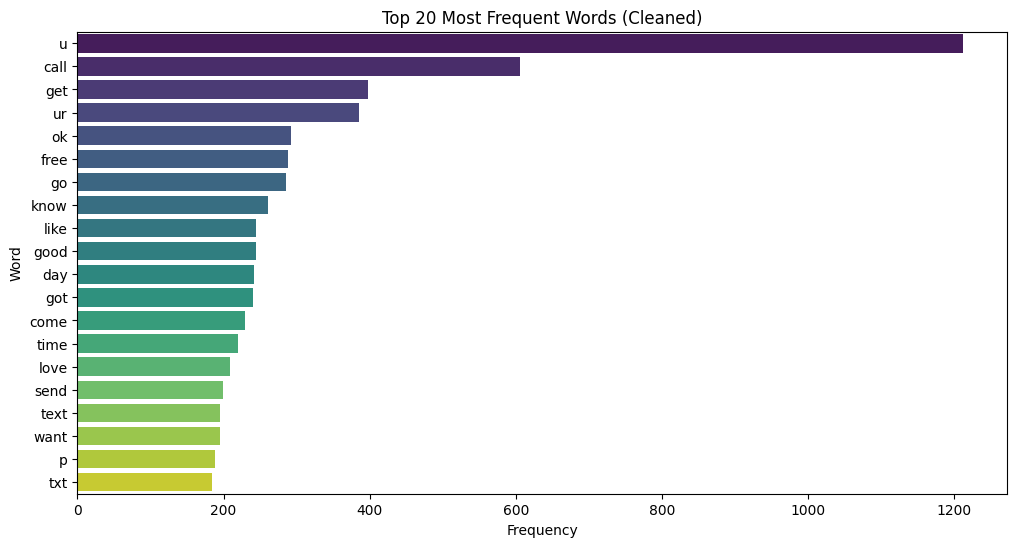

In [8]:
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

# Download stopwords
nltk.download('stopwords')

# Definitions
stop_words = set(stopwords.words('english'))
noise_words = ['lt', 'gt', 'rcv', 'msg', 'reply', 'decimal']

# Clean tokens (remove stopwords and noise words)
df['clean_tokens'] = df['tokens'].apply(
    lambda tokens: [word for word in tokens if word.isalpha()
                    and word not in stop_words and word not in noise_words]
)

# Sample outputs
print("Cleaned tokens (stopwords + noise removed):", *df['clean_tokens'][:5],
      sep="\n")

# Combine all words
all_words = [word for tokens in df['clean_tokens'] for word in tokens]
word_freq = Counter(all_words)

# The 20 most frequent words
common_words = word_freq.most_common(20)
words, counts = zip(*common_words)

# Graphics
plt.figure(figsize=(12,6))
sns.barplot(x=list(counts), y=list(words), palette="viridis")
plt.title("Top 20 Most Frequent Words (Cleaned)")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()


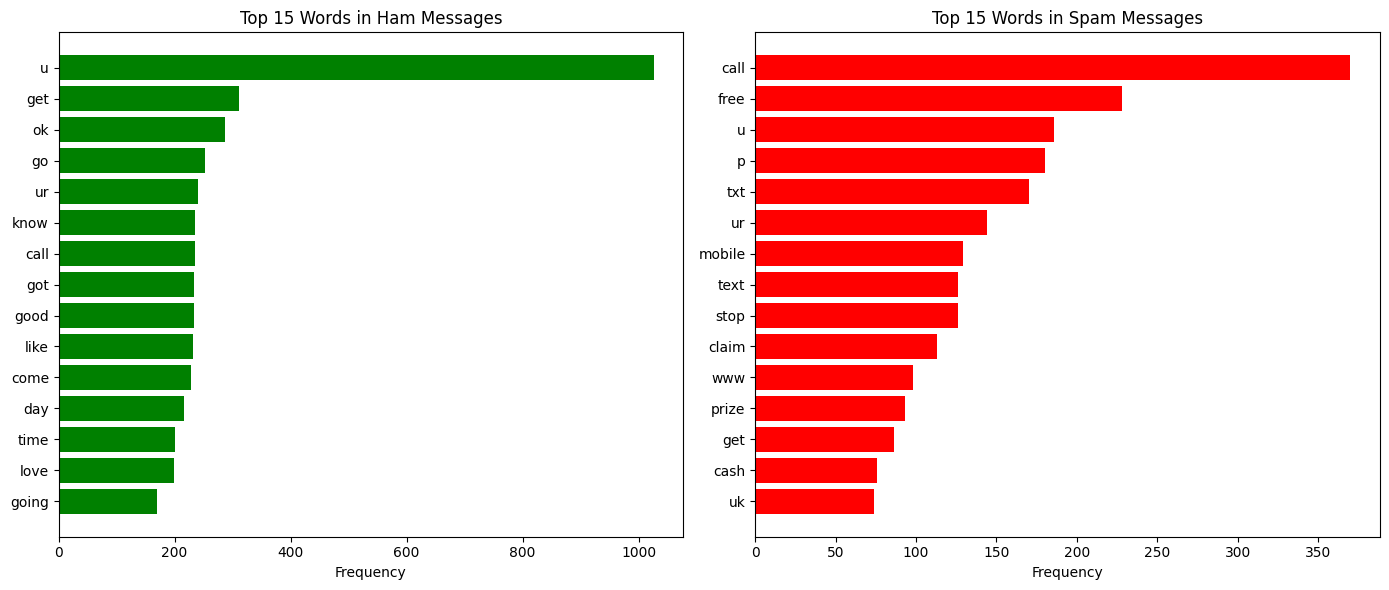

In [9]:
from collections import Counter
import matplotlib.pyplot as plt

# Join all cleaned tokens by group
ham_words = [word for tokens in df[df['label'] == 'ham']['clean_tokens']
             for word in tokens]
spam_words = [word for tokens in df[df['label'] == 'spam']['clean_tokens']
              for word in tokens]

# Count word frequencies
ham_freq = Counter(ham_words).most_common(15)
spam_freq = Counter(spam_words).most_common(15)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].barh(*zip(*reversed(ham_freq)), color='green')
axes[0].set_title("Top 15 Words in Ham Messages")
axes[0].set_xlabel("Frequency")

axes[1].barh(*zip(*reversed(spam_freq)), color='red')
axes[1].set_title("Top 15 Words in Spam Messages")
axes[1].set_xlabel("Frequency")

plt.tight_layout()
plt.show()

# Bigram Trigram Analiz

<ipython-input-10-0fdcfcece6cc>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=vocab, palette='mako')


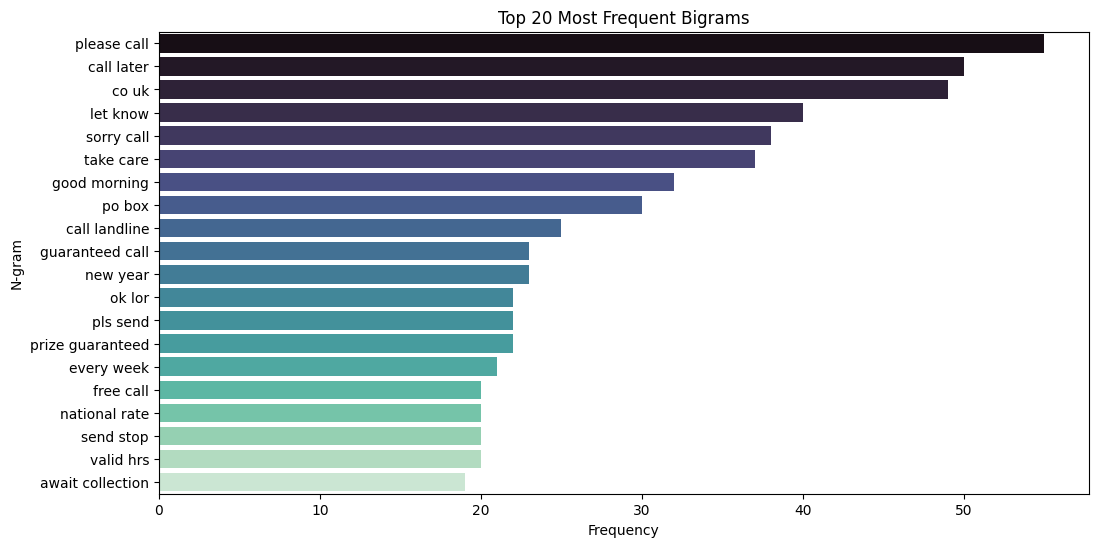

<ipython-input-10-0fdcfcece6cc>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=vocab, palette='mako')


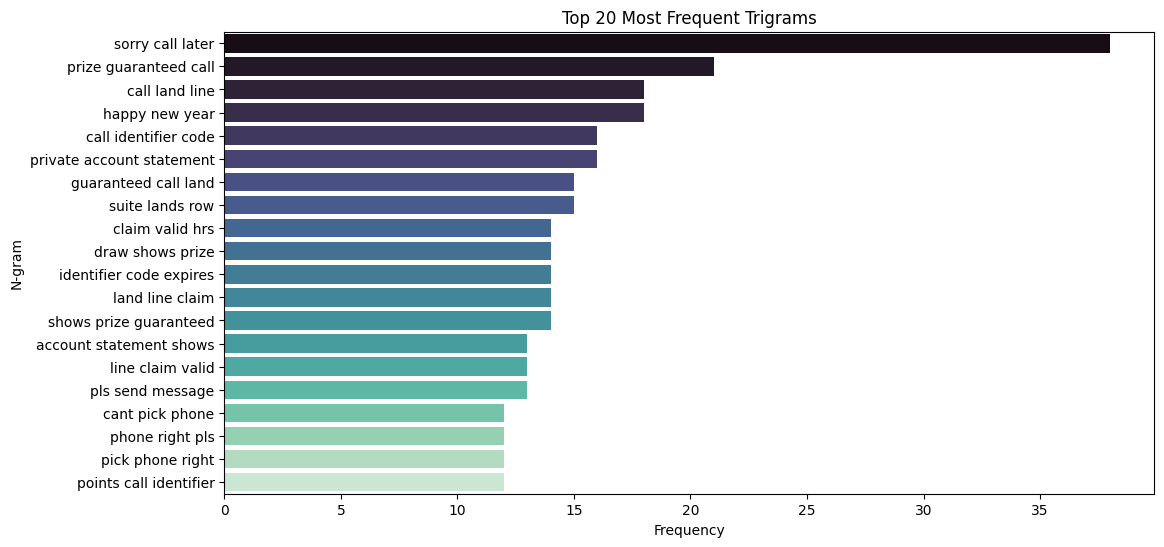

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# Join cleaned tokens into full strings
texts = df['clean_tokens'].apply(lambda tokens: ' '.join(tokens))

# CountVectorizer for bigrams
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=50)
bigram_matrix = bigram_vectorizer.fit_transform(texts)
bigram_counts = bigram_matrix.sum(axis=0).A1
bigram_vocab = bigram_vectorizer.get_feature_names_out()

# CountVectorizer for trigrams
trigram_vectorizer = CountVectorizer(ngram_range=(3, 3), max_features=50)
trigram_matrix = trigram_vectorizer.fit_transform(texts)
trigram_counts = trigram_matrix.sum(axis=0).A1
trigram_vocab = trigram_vectorizer.get_feature_names_out()

# Visualization function
def plot_ngram_bar(vocab, counts, title):
    sorted_idx = sorted(range(len(counts)), key=lambda i: counts[i],
                        reverse=True)
    vocab = [vocab[i] for i in sorted_idx[:20]]
    counts = [counts[i] for i in sorted_idx[:20]]

    plt.figure(figsize=(12,6))
    sns.barplot(x=counts, y=vocab, palette='mako')
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("N-gram")
    plt.show()

# Plot bigrams and trigrams
plot_ngram_bar(bigram_vocab, bigram_counts, "Top 20 Most Frequent Bigrams")
plot_ngram_bar(trigram_vocab, trigram_counts, "Top 20 Most Frequent Trigrams")

# Word Cloud

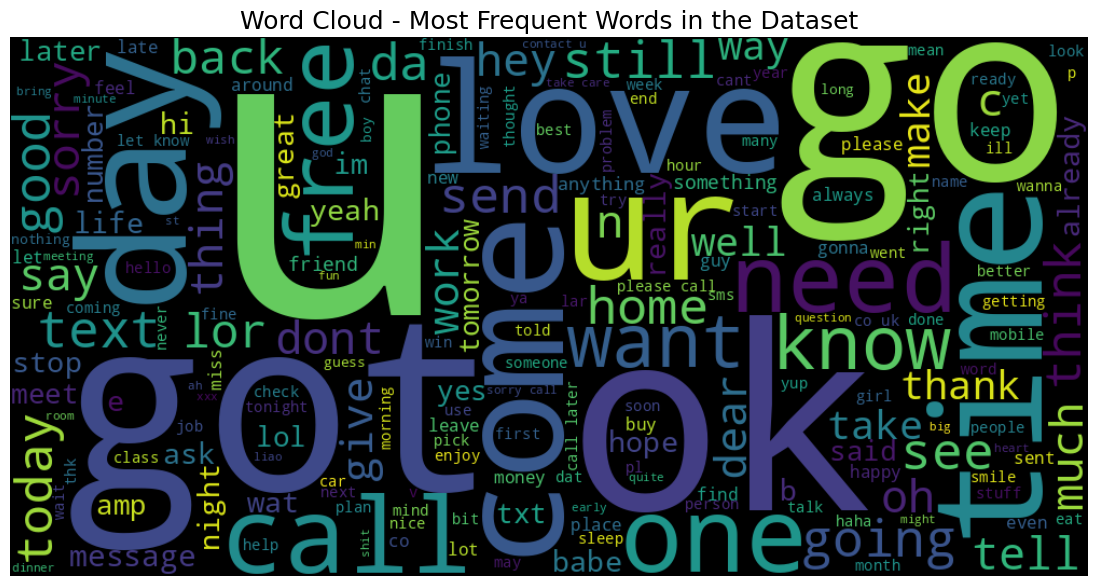

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join all cleaned tokens into one large string
all_text = " ".join([" ".join(tokens) for tokens in df['clean_tokens']])

# Create WordCloud object
wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color='black',
    max_words=200
).generate(all_text)

# Visualize
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Most Frequent Words in the Dataset", fontsize=18)
plt.show()

# Sentiment Analysis

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
<ipython-input-12-b7f8b5903693>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_label', data=df, palette='coolwarm')


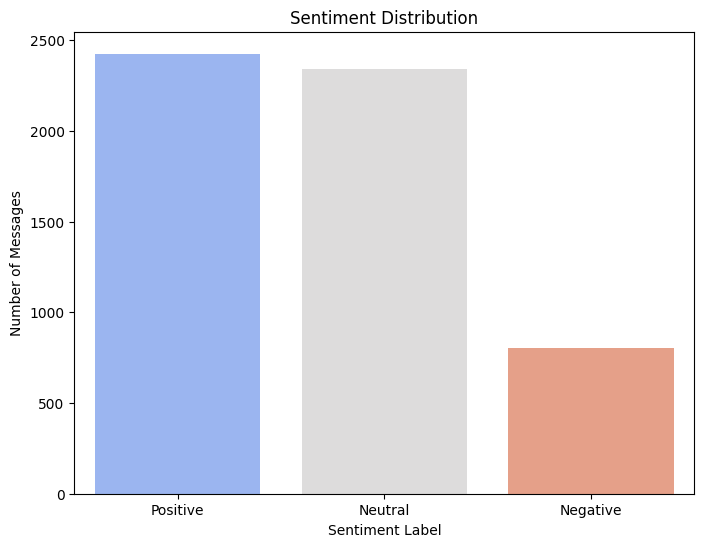

In [12]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

# Download VADER lexicon
nltk.download('vader_lexicon')

# Create SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Compute sentiment score for each message
df['sentiment_score'] = df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Classify as Positive, Neutral, or Negative
def get_sentiment_label(score):
    if score > 0.2:
        return 'Positive'
    elif score < -0.2:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_label'] = df['sentiment_score'].apply(get_sentiment_label)

# Visualize sentiment distribution
plt.figure(figsize=(8,6))
sns.countplot(x='sentiment_label', data=df, palette='coolwarm')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment Label")
plt.ylabel("Number of Messages")
plt.show()

In [13]:
documents = df['clean_tokens'].apply(lambda tokens: ' '.join(tokens))

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_df=0.95, min_df=5, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(documents)


In [15]:
from sklearn.decomposition import LatentDirichletAllocation


lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_output = lda_model.fit_transform(doc_term_matrix)


In [16]:
def print_top_words(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

feature_names = vectorizer.get_feature_names_out()
print_top_words(lda_model, feature_names)


Topic #1: come, happy, day, amp, dear, ur, love, ya, life, special
Topic #2: good, like, love, know, day, hope, think, night, time, great
Topic #3: ur, going, prize, claim, oh, min, contact, cash, urgent, know
Topic #4: got, ok, sorry, da, lor, later, wat, want, ask, hi
Topic #5: free, ur, text, txt, week, stop, uk, lol, www, mobile


<ipython-input-17-b365e9660bce>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='dominant_topic', data=df, palette='Set2')


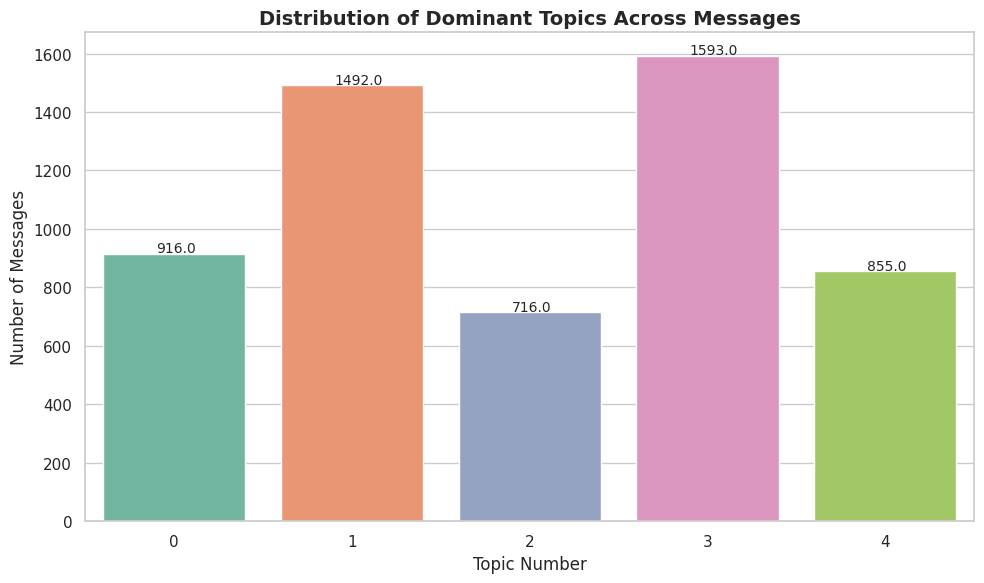

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


topic_values = lda_model.transform(doc_term_matrix)
df['dominant_topic'] = topic_values.argmax(axis=1)

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='dominant_topic', data=df, palette='Set2')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + 0.3, p.get_height() + 5), fontsize=10)

plt.title("Distribution of Dominant Topics Across Messages", fontsize=14, weight='bold')
plt.xlabel("Topic Number", fontsize=12)
plt.ylabel("Number of Messages", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()


# LDA

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Temizlenmiş kelimeleri birleştir
documents = df['clean_tokens'].apply(lambda tokens: ' '.join(tokens))

# CountVectorizer: Boş olmayan ve anlamlı kelimelerle kelime frekans matrisi oluştur
vectorizer = CountVectorizer(
    max_df=0.95,
    min_df=5,
    stop_words='english'
)
doc_term_matrix = vectorizer.fit_transform(documents)

# LDA modeli oluştur ve eğit
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

In [19]:
# Her konunun en yüksek ağırlıklı kelimelerini gör
words = vectorizer.get_feature_names_out()

for index, topic in enumerate(lda.components_):
    print(f"\n🟢 Topic {index+1}:")
    top_words = [words[i] for i in topic.argsort()[-10:]]
    print(" ".join(top_words))


🟢 Topic 1:
special life ya love ur dear amp day happy come

🟢 Topic 2:
great time night think hope day know love like good

🟢 Topic 3:
know urgent cash contact min oh claim prize going ur

🟢 Topic 4:
hi ask want wat later lor da sorry ok got

🟢 Topic 5:
mobile www lol uk stop week txt text ur free



🟢 Topic 1:
special life ya love ur dear amp day happy come

🟢 Topic 2:
great time night think hope day know love like good

🟢 Topic 3:
know urgent cash contact min oh claim prize going ur

🟢 Topic 4:
hi ask want wat later lor da sorry ok got

🟢 Topic 5:
mobile www lol uk stop week txt text ur free


<ipython-input-20-67c2c1a02ecc>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='dominant_topic', data=df, palette='Set2')


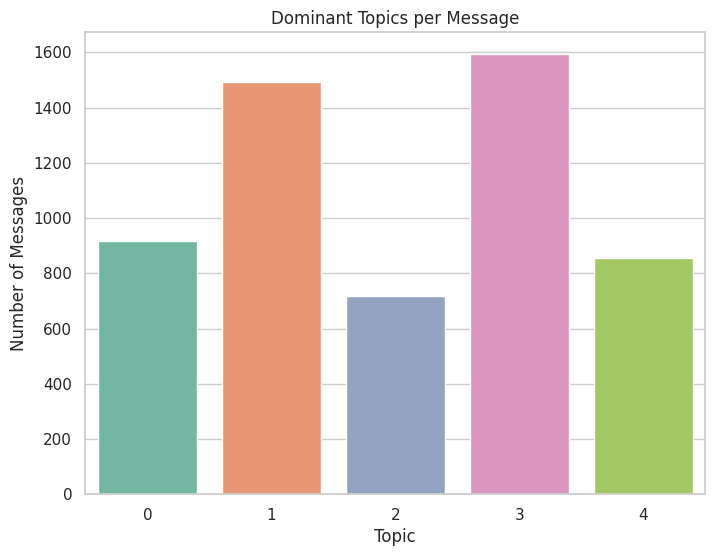

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns

# Temizlenmiş kelimeleri birleştir (örneğin: ['hello', 'world'] -> 'hello world')
documents = df['clean_tokens'].apply(lambda tokens: ' '.join(tokens))

# 1. CountVectorizer ile belge-terim matrisini oluştur
vectorizer = CountVectorizer(
    max_df=0.95,       # %95'ten fazla belgede geçen kelimeleri dışla
    min_df=5,          # En az 5 belgede geçen kelimeleri dahil et
    stop_words='english'  # İngilizce stopword'leri hariç tut
)
doc_term_matrix = vectorizer.fit_transform(documents)

# 2. LDA modelini oluştur ve eğit
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(doc_term_matrix)

# 3. Her konunun en yüksek ağırlıklı kelimelerini görüntüle
words = vectorizer.get_feature_names_out()

for index, topic in enumerate(lda.components_):
    print(f"\n🟢 Topic {index+1}:")
    top_words = [words[i] for i in topic.argsort()[-10:]]  # En yüksek ağırlıklı 10 kelime
    print(" ".join(top_words))

# 4. Her mesaj için dominant (baskın) konuyu belirle
topic_values = lda.transform(doc_term_matrix)
df['dominant_topic'] = topic_values.argmax(axis=1)

# 5. Dominant konu dağılımını görselleştir
plt.figure(figsize=(8, 6))
sns.countplot(x='dominant_topic', data=df, palette='Set2')
plt.title("Dominant Topics per Message")
plt.xlabel("Topic")
plt.ylabel("Number of Messages")
plt.show()


<ipython-input-21-354fe8c861c8>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='dominant_topic', data=df, palette='Set2')


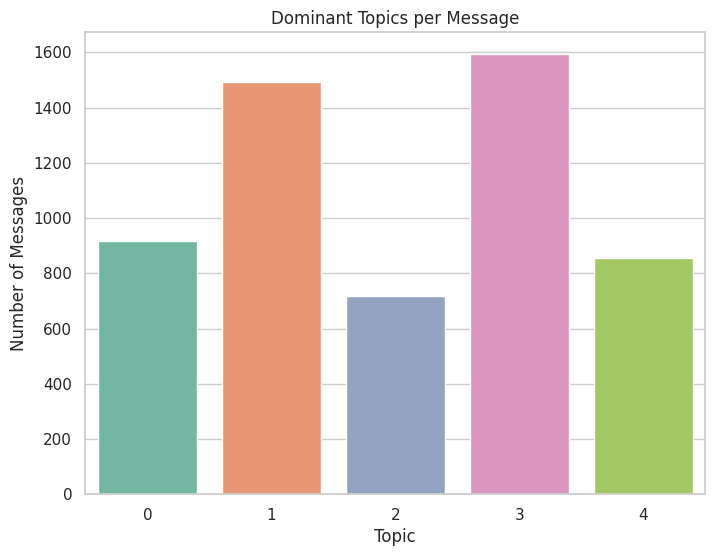

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get topic distribution for each message
topic_values = lda.transform(doc_term_matrix)
df['dominant_topic'] = topic_values.argmax(axis=1)

# Plot
plt.figure(figsize=(8,6))
sns.countplot(x='dominant_topic', data=df, palette='Set2')
plt.title("Dominant Topics per Message")
plt.xlabel("Topic")
plt.ylabel("Number of Messages")
plt.show()

In [22]:
from sklearn.model_selection import train_test_split

X = df['clean_tokens'].apply(lambda x: ' '.join(x))
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

**Model Selection and Training**

In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'SVC': SVC(),
    'Naive Bayes': MultinomialNB(),
    'Decision Tree': DecisionTreeClassifier()
}

for name, model in models.items():
    # f1-weighted = sınıf dengesizliklerini dikkate alır
    scores = cross_val_score(model, X_train_vec, y_train, cv=5, scoring='f1_weighted')
    print(f"{name} F1-Score: {scores.mean():.4f} ± {scores.std():.4f}")

Logistic Regression F1-Score: 0.9467 ± 0.0061
Random Forest F1-Score: 0.9779 ± 0.0038
SVC F1-Score: 0.9716 ± 0.0029
Naive Bayes F1-Score: 0.9628 ± 0.0062
Decision Tree F1-Score: 0.9625 ± 0.0050


# Fine Tune

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                              param_grid,
                              cv=5,
                              scoring='f1_weighted',
                              n_jobs=-1)

grid_search_rf.fit(X_train_vec, y_train)

print("Best Parameters:", grid_search_rf.best_params_)
print("Best Cross-validation F1-Score:", grid_search_rf.best_score_)

Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best Cross-validation F1-Score: 0.9805752275779153


In [27]:
from sklearn.pipeline import make_pipeline

# En iyi modeli al
best_rf_model = grid_search_rf.best_estimator_

# Vektörleştirici + model pipeline
pipeline = make_pipeline(vectorizer, best_rf_model)

In [30]:
# TF-IDF ile dense formata çevir
X_test_array = X_test_vec.toarray()

# SHAP açıklayıcı (önceden tanımlandıysa tekrar tanımlama)
explainer = shap.Explainer(best_rf_model, X_train_vec.toarray())
shap_values = explainer(X_test_array)



100%|===================| 2220/2230 [02:14<00:00]       

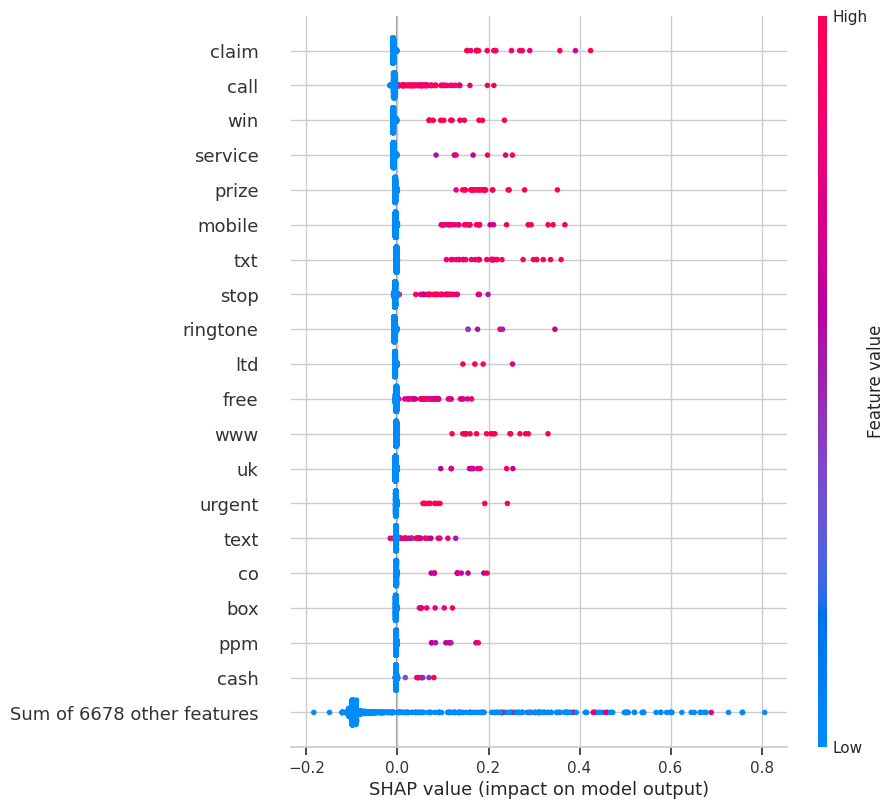

In [31]:
import shap

# TF-IDF sparse matrisini dense forma çevir
X_train_array = X_train_vec.toarray()
X_test_array = X_test_vec[:100].toarray()

# SHAP açıklayıcı
explainer = shap.Explainer(best_rf_model, X_train_array)

# SHAP values for class 1 (spam)
shap_spam = shap_values[..., 1]

# Özellik isimlerini yeniden ekle
shap_spam.feature_names = vectorizer.get_feature_names_out()

# Şimdi yeniden çiz
shap.plots.beeswarm(shap_spam, max_display=20)

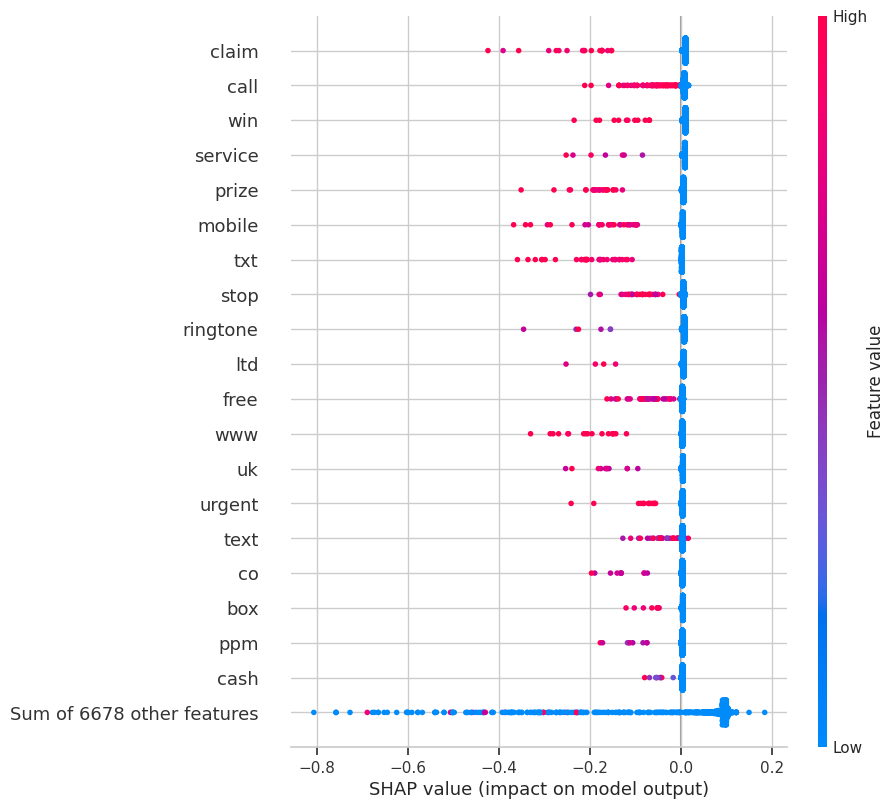

In [32]:
# Ham sınıfı için SHAP değerleri
shap_ham = shap_values[..., 0]

# Özellik isimlerini yeniden ekle
shap_ham.feature_names = vectorizer.get_feature_names_out()

# Beeswarm plot (ham sınıfı için)
shap.plots.beeswarm(shap_ham, max_display=20)

In [34]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 20.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=e5e0c4cc1ed00f0c65e7b49f5522a3bc5ddf4e00aff6db5b76890aa7690036eb
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [35]:
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

# Model ve vektörizer pipeline oluştur
pipeline = make_pipeline(vectorizer, best_rf_model)

# LIME açıklayıcı
lime_explainer = LimeTextExplainer(class_names=['ham', 'spam'])

# Örnek mesaj seç (test setinden)
i = 10  # istediğin örnek için değiştir
example_text = X_test.iloc[i]
print("Mesaj:", example_text)
print("Gerçek Etiket:", y_test.iloc[i])

# LIME açıklamasını üret
lime_exp = lime_explainer.explain_instance(example_text, pipeline.predict_proba, num_features=10)
lime_exp.show_in_notebook(text=True)

Mesaj: sorry call later
Gerçek Etiket: ham


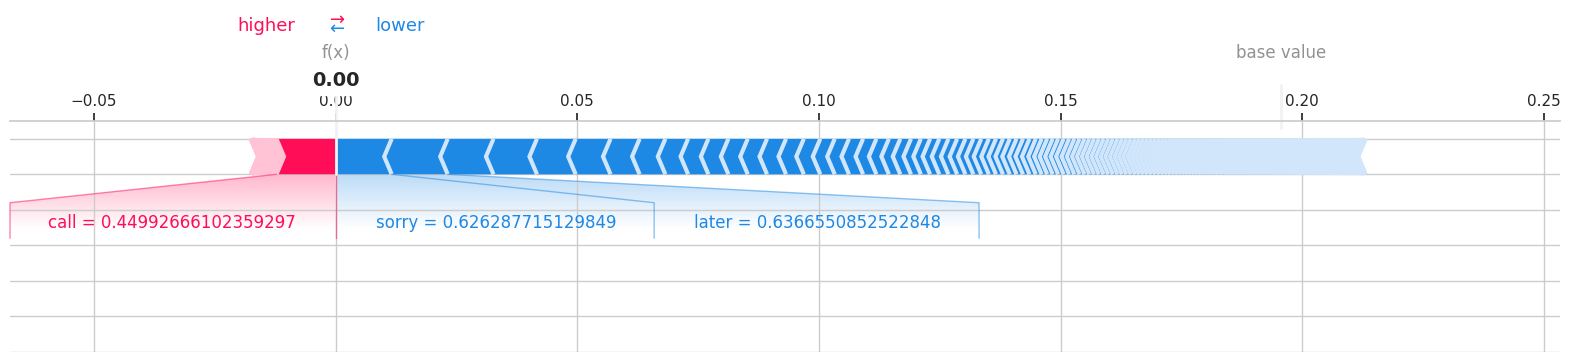

In [36]:
shap.force_plot(
    base_value=explainer.expected_value[1],
    shap_values=shap_values[10].values[:, 1],
    features=X_test_array[10],
    feature_names=vectorizer.get_feature_names_out(),
    matplotlib=True
)

Testing

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# En iyi model ile tahmin
y_pred_rf = grid_search_rf.predict(X_test_vec)

# Test performans sonuçları
print("Test Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, pos_label='spam'))
print("Recall:", recall_score(y_test, y_pred_rf, pos_label='spam'))
print("F1 Score:", f1_score(y_test, y_pred_rf, pos_label='spam'))

print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Test Accuracy: 0.9820627802690582
Precision: 0.9923664122137404
Recall: 0.87248322147651
F1 Score: 0.9285714285714286

Classification Report:
               precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.99      0.87      0.93       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [38]:
from sklearn.pipeline import make_pipeline

# En iyi modeli al
best_rf_model = grid_search_rf.best_estimator_

# Vektörleştirici + model pipeline
pipeline = make_pipeline(vectorizer, best_rf_model)

In [39]:
from lime.lime_text import LimeTextExplainer

class_names = ['ham', 'spam']
explainer = LimeTextExplainer(class_names=class_names)

i = 7  # örnek indeks
example_text = X_test.iloc[i]
print("Mesaj:", example_text)
print("Gerçek Etiket:", y_test.iloc[i])

exp = explainer.explain_instance(example_text, pipeline.predict_proba, num_features=8)
exp.show_in_notebook(text=True)

Mesaj: dont talk ever ok word
Gerçek Etiket: ham
